In [1]:
from itertools import product

import numpy as np
import pandas as pd
from functions import *


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [15]:
from itertools import product
from sys import argv

import numpy as np
import pandas as pd
from functions import *
from statsmodels.nonparametric.kernel_regression import KernelReg


# heteroscedastic = [False]
# p must be p>4
p = [10]
n = [2000]
#treatment_to_noise_ratio = np.logspace(start=0.0, stop=1.25, num=50) # from 0.25 to 20
#treatment_to_noise_ratio = np.linspace(start=1.0, stop = 8.00, num=50)
 # 2.5 - 7.5
    
treatment_to_noise_ratio = [1,2,3,4,15.0]

# (n, p, X_dist, X_correlation, eps_dist, error_type, functional_form, non_zero_beta_count, uniform_upper, standardized_X, method, sim_id)

n_sims = 3


main_effect_cases = ["const", "linear","non-linear"]
#main_effect_cases = ["non-linear"]

treatment_cases = ["binary","gaussian"]

methods = {
    "quantreg_forest": quantreg_forest,
    #"pred_band_mean_based_new": pred_band_mean_based_new,
    #"pred_band_weighted_mean_based": pred_band_weighted_mean_based,
    #"pred_band_quantile_based_rf": pred_band_quantile_based_rf,
    #"pred_band_cdf_based": pred_band_cdf_based,
}


methods_keys = list(methods.keys())

simulation_ids = np.arange(n_sims)

index = product(n, p, treatment_to_noise_ratio, main_effect_cases, methods_keys, treatment_cases, simulation_ids)

index = pd.MultiIndex.from_tuples(
    index,
    names=(
        "n",
        "p",
        "treatment_to_noise_ratio",
        "main_effect_case",
        "conformal_method",
        "treatment_case",
        "simulation_id",
    ),
)

df = pd.DataFrame(
    columns=[
        "mean_interval_length_qf",
        "mean_coverage_qf",
        "mean_oracle_length",
        "share_signif_oracles_given_ite_nonzero",
        "share_signif_intervals_given_ite_nonzero"  
    ],
    index=index,
)


In [20]:
df.head(15)

mean_interval_length_qf  \
n    p  treatment_to_noise_ratio main_effect_case conformal_method treatment_case simulation_id                           
2000 10 1.0                      const            quantreg_forest  binary         0                            6.764362   
                                                                                  1                            6.873536   
                                                                                  2                            6.583224   
                                                                   gaussian       0                            7.493105   
                                                                                  1                            7.217203   
                                                                                  2                            7.297959   
                                 linear           quantreg_forest  binary         0                           12.809313   
                                                                                  1                           12.558475   
                                                                                  2                           12.734607   
                                                                   gaussian       0                           13.496401   
                                                                                  1                           13.261215   
                                                                                  2                           13.897051   
                                 non-linear       quantreg_forest  binary         0                           13.655668   
                                                                                  1                           12.859917   
                                                                                  2                           13.143584   

                                                                                                mean_coverage_qf  \
n    p  treatment_to_noise_ratio main_effect_case conformal_method treatment_case simulation_id                    
2000 10 1.0                      const            quantreg_forest  binary         0                       0.9775   
                                                                                  1                        0.981   
                                                                                  2                        0.983   
                                                                   gaussian       0                       0.9885   
                                                                                  1                       0.9805   
                                                                                  2                       0.9865   
                                 linear           quantreg_forest  binary         0                       0.9995   
                                                                                  1                          1.0   
                                                                                  2                          1.0   
                                                                   gaussian       0                          1.0   
                                                                                  1                          1.0   
                                                                                  2                          1.0   
                                 non-linear       quantreg_forest  binary         0                       0.9985   
                                                                                  1                       0.9985   
                                                                                  2                        0.999   

                               

In [17]:
for index in df.index:
    print(str(index))
    pred_samples = 2000
    total_sample = index[0] + pred_samples
    
    # generate train and test sample:
    ite, mu_1, mu_0, eps_1, eps_0, y_obs, X, W = dgp_ate_zero(n = index[0],
                                                             p = index[1], 
                                                             effect_size = index[2],
                                                             main_effect_case= index[3],
                                                             treatment_case = index[5])
   
    # split the generated data into respective categories, one split for each counterfactual:
    
    # Y(1) | W = 1:
    #X_train_1, y_train_1 = X[W==1], y_obs[W==1]
    
    # Y(0) | W = 0:
    #X_train_0, y_train_0 = X[W==0], y_obs[W==0]
    
    # draw new samples for later prediction:
    ite_pred, mu_1_pred, mu_0_pred, eps_1_pred, eps_0_pred, y_obs_pred, X_pred, W_pred = dgp_ate_zero(n = pred_samples,
                                                                     p = index[1], 
                                                                     effect_size = index[2],
                                                                     main_effect_case= index[3],
                                                                     treatment_case = index[5])

    
    res_y_1 = quantreg_forest(X_train=X[W==1], y_train=y_obs[W==1], X_test=X_pred, lower=0.05, upper=0.95, nodesize=10)
    res_y_0 = quantreg_forest(X_train=X[W==0], y_train=y_obs[W==0], X_test=X_pred, lower=0.05, upper=0.95, nodesize=10)
    
    
    lower = res_y_1[:, 0] - res_y_0[:, 1] 
    upper = res_y_1[:, 1] - res_y_0[:, 0] 
    
    ite_bands = np.stack((lower.flatten(), upper.flatten()), axis=1)
                                                                                                         
    length_bands = ite_bands[:, 1] - ite_bands[:, 0]
    mean_interval_length = np.mean(length_bands)

    in_the_range = np.sum(
        (ite_pred.flatten() >= ite_bands[:, 0]) & (ite_pred.flatten() <= ite_bands[:, 1])
    )
    mean_coverage = in_the_range / len(ite_pred)
    
    # get oracle intervals for the ite's:
    oracle_ints = np.stack(get_oracle_intervals(*calc_normal_params(mu_1= mu_1_pred, mu_0= mu_0_pred, X =X_pred, heteroscedastic=False)), axis=0)
    length_oracle_ints = oracle_ints[:, 1] - oracle_ints[:, 0]
    mean_oracle_length = np.mean(length_oracle_ints)
    
    assert oracle_ints.shape[0] == ite_bands.shape[0]
    assert oracle_ints.shape[1] == ite_bands.shape[1]
    
    
    df.at[index, "mean_interval_length_qf"] = mean_interval_length
    df.at[index, "mean_coverage_qf"] = mean_coverage
    df.at[index, "mean_oracle_length"] = mean_oracle_length
    
    #df.at[index, "share_intervals_signif_if_oracle_signif"] = share_signif_fun(oracle_ints, ite_bands)                                                       
    df.at[index, "share_signif_oracles_given_ite_nonzero"] = share_signif_oracles(oracle_intervals=oracle_ints, ite_vals=ite_pred)                                                                                              
    df.at[index, "share_signif_intervals_given_ite_nonzero"] = share_signif_intervals_given_ite_not_zero(ite_pred_intervals=ite_bands, ite_vals=ite_pred)
                                                                                                         


(2000, 10, 1.0, 'const', 'quantreg_forest', 'binary', 0)
(2000, 10, 1.0, 'const', 'quantreg_forest', 'binary', 1)
(2000, 10, 1.0, 'const', 'quantreg_forest', 'binary', 2)
(2000, 10, 1.0, 'const', 'quantreg_forest', 'gaussian', 0)
(2000, 10, 1.0, 'const', 'quantreg_forest', 'gaussian', 1)
(2000, 10, 1.0, 'const', 'quantreg_forest', 'gaussian', 2)
(2000, 10, 1.0, 'linear', 'quantreg_forest', 'binary', 0)
(2000, 10, 1.0, 'linear', 'quantreg_forest', 'binary', 1)
(2000, 10, 1.0, 'linear', 'quantreg_forest', 'binary', 2)
(2000, 10, 1.0, 'linear', 'quantreg_forest', 'gaussian', 0)
(2000, 10, 1.0, 'linear', 'quantreg_forest', 'gaussian', 1)
(2000, 10, 1.0, 'linear', 'quantreg_forest', 'gaussian', 2)
(2000, 10, 1.0, 'non-linear', 'quantreg_forest', 'binary', 0)
(2000, 10, 1.0, 'non-linear', 'quantreg_forest', 'binary', 1)
(2000, 10, 1.0, 'non-linear', 'quantreg_forest', 'binary', 2)
(2000, 10, 1.0, 'non-linear', 'quantreg_forest', 'gaussian', 0)
(2000, 10, 1.0, 'non-linear', 'quantreg_forest',

In [5]:
# generate train and test sample:
ite, mu_1, mu_0, eps_1, eps_0, y_obs, X, W = dgp_ate_zero(n = 20000,
                                                            p = 10,
                                                             effect_size = 1.0,
                                                             main_effect_case= "linear",
                                                             treatment_case = "binary")

In [8]:
X_train_1, X_conf_1, y_train_1, y_conf_1 = train_test_split(
        X[W==1], y_obs[W==1], test_size=0.3, train_size=0.7)
    
# Y(0) | W = 0:
X_train_0, X_conf_0, y_train_0, y_conf_0 = train_test_split(
        X[W==0], y_obs[W==0], test_size=0.3, train_size=0.7)

In [6]:
ite_pred, mu_1_pred, mu_0_pred, eps_1_pred, eps_0_pred, y_obs_pred, X_pred, W_pred = dgp_ate_zero(n = 2000,
                                                                     p = 10, 
                                                                     effect_size = 1.0,
                                                                     main_effect_case= "linear",
                                                                     treatment_case = "binary")

In [7]:
res = quantreg_forest(X_train=X[W==1], y_train=y_obs[W==1], X_test=X_pred, lower=0.05, upper=0.95, nodesize=10)

In [2]:
def plot_func(x,
              y,
              y_u=None,
              y_l=None,
              pred=None,
              shade_color="",
              method_name="",
              title="",
              filename=None,
              save_figures=False):
    
    """ Scatter plot of (x,y) points along with the constructed prediction interval 
    
    Parameters
    ----------
    x : numpy array, corresponding to the feature of each of the n samples
    y : numpy array, target response variable (length n)
    pred : numpy array, the estimated prediction. It may be the conditional mean,
           or low and high conditional quantiles.
    shade_color : string, desired color of the prediciton interval
    method_name : string, name of the method
    title : string, the title of the figure
    filename : sting, name of the file to save the figure
    save_figures : boolean, save the figure (True) or not (False)
    
    """
    
    x_ = x[:max_show]
    y_ = y[:max_show]
    if y_u is not None:
        y_u_ = y_u[:max_show]
    if y_l is not None:
        y_l_ = y_l[:max_show]
    if pred is not None:
        pred_ = pred[:max_show]

    fig = plt.figure()
    inds = np.argsort(np.squeeze(x_))
    plt.plot(x_[inds,:], y_[inds], 'k.', alpha=.2, markersize=10,
             fillstyle='none', label=u'Observations')
    
    if (y_u is not None) and (y_l is not None):
        plt.fill(np.concatenate([x_[inds], x_[inds][::-1]]),
                 np.concatenate([y_u_[inds], y_l_[inds][::-1]]),
                 alpha=.3, fc=shade_color, ec='None',
                 label = method_name + ' prediction interval')
    
    if pred is not None:
        if pred_.ndim == 2:
            plt.plot(x_[inds,:], pred_[inds,0], 'k', lw=2, alpha=0.9,
                     label=u'Predicted low and high quantiles')
            plt.plot(x_[inds,:], pred_[inds,1], 'k', lw=2, alpha=0.9)
        else:
            plt.plot(x_[inds,:], pred_[inds], 'k--', lw=2, alpha=0.9,
                     label=u'Predicted value')
    
    plt.ylim([-2.5, 7])
    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    plt.legend(loc='upper right')
    plt.title(title)
    if save_figures and (filename is not None):
        plt.savefig(filename, bbox_inches='tight', dpi=300)
    
    plt.show()

In [26]:
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import check_X_y, check_array
from sklearn.utils.validation import check_is_fitted
import matplotlib.pyplot as plt
from sklearn.ensemble._gb import BaseGradientBoosting

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from copy import deepcopy
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import iqr

import sys

In [7]:
sys.path.append('..')
from conformal_methods.utils import init_scoring_object, CQR_conformity_score, conditional_cdf_hat, p_y_func, extract_intervals
from conformal_methods.r_objects import QuantregForest
from conformal_methods.testing_dgps import testing_dgp_1

In [27]:
class SplitConformalRegressor(BaseEstimator, RegressorMixin):
    valid_methods_ = ["mean-based","weighted-mean-based","quantile-based","cdf-based"]

    def __init__(self, estimator = None, method= "mean-based", conf_size=0.5, param_grid=None, quantiles_to_fit=np.array([0.05,0.95])):

        regressor = estimator()
        
        if isinstance(regressor, RegressorMixin):
            self.estimator = estimator
        else:
            raise ValueError("Invalid estimator argument. Must be a regressor.")
            
        if method in SplitConformalRegressor.valid_methods_:
            if (method == "quantile-based") & ((isinstance(regressor, QuantregForest)) | (isinstance(regressor, BaseGradientBoosting))):
                pass
            elif ((method == "mean-based") | (method == "weighted-mean-based")) & ~(isinstance(regressor, QuantregForest)):
                pass
            elif (method == "cdf-based") & (isinstance(regressor, QuantregForest)):
                pass
            else:
                raise ValueError("Invalid combination of input method and regressor.")
            self.method = method

        else:
            raise ValueError("Invalid method. Allowed values are 'mean-based','weighted-mean-based','quantile-based', and 'cdf-based'.")
            
        if (conf_size > 0.0) & (conf_size < 1.0):
            self.conf_size = conf_size
        else:
            raise ValueError("Invalid size for the conformalization size. Accepted values are between 0 and 1.")
        
        self.param_grid = param_grid
        self.quantiles_to_fit = quantiles_to_fit


    def _check_estimator(self, estimator = None):
        if estimator is None:
            raise ValueError("Please specify valid estimator.")

        regressor = estimator()
        if not hasattr(regressor, "fit") and not hasattr(regressor, "predict"):
            raise ValueError("Invalid estimator. Please provide a regressor with fit and predict methods.")
     
        return estimator
    
    def fit(self, X, y, params={}): 
        # checks
        estimator = self._check_estimator(self.estimator)
        X, y = check_X_y(X, y, force_all_finite=False, dtype=["float64", "int", "object"])
        # split sample
        X_train, X_conf, y_train, y_conf = train_test_split(X, y, test_size=self.conf_size)
        self.X_conf_ = X_conf
        self.y_conf_ = y_conf

        # training
        if self.method == "mean-based":
            if isinstance(params, dict):
                self.mu_hat_ = estimator(**params).fit(X_train, y_train)
            elif isinstance(params, list):
                self.mu_hat_ = estimator(**(params[0].best_params_)).fit(X_train, y_train)
            else:
                raise ValueError("Invalid type of parameter 'params'; must be dict or list type.")
            
        if self.method == "weighted-mean-based":
            if isinstance(params, dict):
                self.mu_hat_ = estimator(**params).fit(X_train, y_train)
                self.mu_hat_train_residuals_ = self.mu_hat_.predict(X_train)
                
                self.fitted_abs_res_ = np.abs(y_train.flatten() - self.mu_hat_train_residuals_.flatten())
                self.rho_hat_ = estimator(**params).fit(X_train, self.fitted_abs_res_)

            elif isinstance(params, list):
                self.mu_hat_ = estimator(**(params[0].best_params_)).fit(X_train, y_train)
                self.mu_hat_train_residuals_ = self.mu_hat_.predict(X_train)
                
                self.fitted_abs_res_ = np.abs(y_train.flatten() - self.mu_hat_train_residuals_.flatten())
                self.rho_hat_ = estimator(**(params[0].best_params_)).fit(X_train, self.fitted_abs_res_)
            else:
                raise ValueError("Invalid type of parameter 'params'; must be dict or list type.")

        if self.method == "quantile-based":
            # check if the tune method has been called before:
            # in that case, we have to modify the quantiles 
           
            if isinstance(estimator(), QuantregForest):
                # this is the untuned case when a simple dict is provided as params
                if isinstance(params, dict):
                    params["quantile_to_fit"] = self.quantiles_to_fit
                    if (len(params["quantile_to_fit"]) == 2):
                        # this quantile_to_fit param is unique for the quantregForest from Meinshausen (2006), 
                        # since alpha is the param for the quantiles to fit
                        self.fitted_quant_reg_forest_both_ = estimator(**params).fit(X_train, y_train)
                        self.quantiles_to_fit_ = params["quantile_to_fit"]
                    else:
                        raise ValueError("The quantile_to_fit param must have length of two.")
                # this is the tuned case, when a list of 2 optimal param cv_objects is provided        
                elif isinstance(params, list):
                    if (len(self.quantiles_to_fit) == 2) & (len(params) == 2):
                        params_lower = params[0].best_params_
                        params_lower["quantile_to_fit"] = self.quantiles_to_fit[0]
                        params_upper = params[1].best_params_
                        params_upper["quantile_to_fit"] = self.quantiles_to_fit[1]
                    
                        self.fitted_quant_reg_forest_lower_ = estimator(**params_lower).fit(X_train, y_train)
                        self.fitted_quant_reg_forest_upper_ = estimator(**params_upper).fit(X_train, y_train)
                        self.quantiles_to_fit_ = self.quantiles_to_fit
                    else:
                        raise ValueError("The 'quantiles_to_fit' param during initialization must have length of two.")

                else:
                    raise ValueError("Invalid type of parameter 'params'; must be dict or list type.")

            elif (isinstance(self.estimator(), BaseGradientBoosting)):
                assert len(self.quantiles_to_fit) == 2
                self.quantiles_to_fit_ = self.quantiles_to_fit
                if isinstance(params, dict):
                    params["loss"] = 'quantile'
                    params["alpha"] = self.quantiles_to_fit
                    lower_params = deepcopy(params)
                    upper_params = deepcopy(params)
                    lower_params["alpha"] = lower_params["alpha"][0]
                    upper_params["alpha"] = upper_params["alpha"][1]
                
                elif isinstance(params, list):
                    lower_params = params[0].best_params_
                    upper_params = params[1].best_params_

                    lower_params["loss"] = 'quantile'
                    lower_params["alpha"] = self.quantiles_to_fit[0]
                    upper_params["loss"] = 'quantile'
                    upper_params["alpha"] = self.quantiles_to_fit[1]

                else:
                    raise ValueError("Invalid type of parameter 'params'; must be dict or list type.")

                self.fitted_quant_reg_forest_lower_ = estimator(**lower_params).fit(X_train, y_train)
                self.fitted_quant_reg_forest_upper_ = estimator(**upper_params).fit(X_train, y_train)
                    
            else:
                raise ValueError("Invalid estimator or params. Please provide a quantile regression estimator with the corresponding params.")

        if self.method == "cdf-based":
            # valid params:
            # valid_params_cdf = ["nodesize", "mtry", "ntree"]

            if not isinstance(params, dict):
                raise ValueError("Only a dict of params is accepted, no tuning available at the moment.")

            if not isinstance(estimator(), QuantregForest):
                raise ValueError("Only a 'QuantregForest' from Meinshausen(2006) available at the moment.")

            y_grid_upper = np.max(y) + iqr(y)
            y_grid_lower = np.min(y) - iqr(y)

            self.y_grid_cdf_ = np.linspace(y_grid_lower, y_grid_upper, 15000)
            self.quantile_grid_cdf_ = np.linspace(0.001, 0.999, 100)
            if not "quantile_to_fit" in params:
                params["quantile_to_fit"] = self.quantile_grid_cdf_

            self.fitted_quant_reg_forest_cdf_ = estimator(**params).fit(X_train, y_train)
            
        return self

    def tune(self, X, y, quantile=np.array([0.9]), cv=5):
        # "quantile" param must be length 1 for mean based and weighted approach, and length 2 for quantile based approach;
        # also "quantile" must coincide with the "quantiles_to_fit" param during initialization of estimator for quantile based approach
        estimator = self._check_estimator(self.estimator)
        X, y = check_X_y(X, y, force_all_finite=False, dtype=["float64", "int", "object"])

        if self.method == "cdf-based":
            raise ValueError("This method cannot be tuned at the moment.")

        if not self.param_grid:
            raise ValueError("Please reinitialize the SplitConformalRegressor with a parameter grid for tuning.")
            
        # if self.method == "quantile-based":
        #     self.param_grid["loss"] = ['quantile']
        #     self.param_grid["alpha"] = [quantile]

        if self.param_grid is not None:
            if self.method != "quantile-based":
                assert len(quantile) == 1
                scoring_object = init_scoring_object(method=self.method, quantile=quantile)
                grid = GridSearchCV(estimator(), self.param_grid, cv=cv, scoring=scoring_object)
                grid.fit(X, y)
                # self.cv_results_ = grid.best_params_
                return [grid]
            else:
                #assert np.array_equal(quantile,self.quantiles_to_fit)
                assert len(self.quantiles_to_fit) == 2

                lower_params = deepcopy(self.param_grid)
                upper_params = deepcopy(self.param_grid)

                lower_params["loss"] = ['quantile']
                upper_params["loss"] = ['quantile']
                
                lower_params["alpha"] = [self.quantiles_to_fit[0]]
                upper_params["alpha"] = [self.quantiles_to_fit[1]]

                scoring_object_lower = init_scoring_object(method=self.method, quantile=self.quantiles_to_fit[0])
                grid_lower = GridSearchCV(estimator(), lower_params, cv=cv, scoring=scoring_object_lower)
                grid_lower.fit(X, y)

                scoring_object_upper = init_scoring_object(method=self.method, quantile=self.quantiles_to_fit[1])
                grid_upper = GridSearchCV(estimator(), upper_params, cv=cv, scoring=scoring_object_upper)
                grid_upper.fit(X, y)

                return [grid_lower, grid_upper]

        else:
            raise ValueError("Invalid call, since no parameters for tuning have been defined.")

    def predict_intervals(self, X_pred, alpha=0.1):
        X_pred = check_array(X_pred, force_all_finite=False, dtype=["float64", "object"])
        
        if self.method == "mean-based":
            check_is_fitted(self,["mu_hat_"])
            y_pred_hat = self.mu_hat_.predict(X_pred)
            y_conf_hat = self.mu_hat_.predict(self.X_conf_)
            
            conf_scores = np.abs(self.y_conf_ - y_conf_hat)
            k = (1 - alpha) * (1.0 / len(self.y_conf_) + 1)
            d = np.quantile(conf_scores, k)

            pred_band_upper = y_pred_hat + d
            pred_band_lower = y_pred_hat - d

            res = np.stack((pred_band_lower.flatten(), pred_band_upper.flatten()), axis=1)
            return res
        
        if self.method == "weighted-mean-based":
            check_is_fitted(self,["mu_hat_","mu_hat_train_residuals_","fitted_abs_res_","rho_hat_"])
            
            y_pred_hat = self.mu_hat_.predict(X_pred)
            y_conf_hat = self.mu_hat_.predict(self.X_conf_)
            
            y_pred_mad_hat = self.rho_hat_.predict(X_pred)
            y_conf_mad_hat = self.rho_hat_.predict(self.X_conf_)
            
            conf_scores = np.abs(self.y_conf_.flatten() - y_conf_hat.flatten()) / y_conf_mad_hat.flatten()
            k = (1 - alpha) * (1.0 / len(self.y_conf_) + 1)
            d = np.quantile(conf_scores, k)

            pred_band_upper = y_pred_hat + y_pred_mad_hat * d
            pred_band_lower = y_pred_hat - y_pred_mad_hat * d

            res = np.stack((pred_band_lower.flatten(), pred_band_upper.flatten()), axis=1)
            return res
        
        if self.method == "quantile-based":
            if hasattr(self, "fitted_quant_reg_forest_both_"):
                check_is_fitted(self,["fitted_quant_reg_forest_both_"])
                assert len(self.quantiles_to_fit_) == 2
                # generate upper and lower quantile estimates at the same time for both sets
                y_conf_hat = self.fitted_quant_reg_forest_both_.predict(self.X_conf_)
                y_pred_hat = self.fitted_quant_reg_forest_both_.predict(X_pred)

                conf_scores = CQR_conformity_score(lower_quant_hat=y_conf_hat[:, 0], upper_quant_hat=y_conf_hat[:, 1], y_conf=self.y_conf_)
                k = (1 - alpha) * (1.0 / len(self.y_conf_) + 1)
                d = np.quantile(conf_scores, k)

                pred_band_upper = y_pred_hat[:, 1] + d
                pred_band_lower = y_pred_hat[:, 0] - d

                res = np.stack((pred_band_lower.flatten(), pred_band_upper.flatten()), axis=1)

            elif (hasattr(self, "fitted_quant_reg_forest_lower_")) & (hasattr(self, "fitted_quant_reg_forest_upper_")):
                check_is_fitted(self,["fitted_quant_reg_forest_lower_"])
                check_is_fitted(self,["fitted_quant_reg_forest_upper_"])
                assert len(self.quantiles_to_fit_) == 2

                y_conf_hat_lower = self.fitted_quant_reg_forest_lower_.predict(self.X_conf_)
                y_conf_hat_upper = self.fitted_quant_reg_forest_upper_.predict(self.X_conf_)

                y_pred_hat_lower = self.fitted_quant_reg_forest_lower_.predict(X_pred)
                y_pred_hat_upper = self.fitted_quant_reg_forest_upper_.predict(X_pred)

                conf_scores = CQR_conformity_score(lower_quant_hat=y_conf_hat_lower, upper_quant_hat=y_conf_hat_upper, y_conf=self.y_conf_)
                k = (1 - alpha) * (1.0 / len(self.y_conf_) + 1)
                d = np.quantile(conf_scores, k)

                pred_band_upper = y_pred_hat_upper + d
                pred_band_lower = y_pred_hat_lower - d

                res = np.stack((pred_band_lower.flatten(), pred_band_upper.flatten()), axis=1)
            
            else:
                raise ValueError("No correct quantile regressor was fitted previously.")

            return res

        if self.method == "cdf-based":
            if hasattr(self, "fitted_quant_reg_forest_cdf_"):
                check_is_fitted(self,["fitted_quant_reg_forest_cdf_"])

                y_conf_hat = self.fitted_quant_reg_forest_cdf_.predict(self.X_conf_)
                y_pred_hat = self.fitted_quant_reg_forest_cdf_.predict(X_pred)
                
                f_hat_conf, f_hat_y_mat = conditional_cdf_hat(y_grid=self.y_grid_cdf_, 
                                                            y_vec=self.y_conf_, 
                                                            q_hat_conf_mat=y_conf_hat, 
                                                            q_hat_pred_mat=y_pred_hat)
                
                conf_set_list = p_y_func(alpha=alpha, y_grid=self.y_grid_cdf_, f_hat_conf=f_hat_conf, f_hat_y_mat=f_hat_y_mat)
                res = extract_intervals(conf_set_list)

            return res

In [8]:
# class SplitConformalRegressor(BaseEstimator, RegressorMixin):
#     valid_methods_ = ["mean-based","weighted-mean-based","quantile-based","cdf-based"]

#     def __init__(self, estimator = None, method= "mean-based", conf_size=0.5, param_grid=None, quantiles_to_fit=np.array([0.05,0.95])):

#         regressor = estimator()
        
#         if isinstance(regressor, RegressorMixin):
#             self.estimator = estimator
#         else:
#             raise ValueError("Invalid estimator argument. Must be a regressor.")
            
#         if method in SplitConformalRegressor.valid_methods_:
#             if (method == "quantile-based") & ((isinstance(regressor, QuantregForest)) | (isinstance(regressor, BaseGradientBoosting))):
#                 pass
#             elif ((method == "mean-based") | (method == "weighted-mean-based")) & ~(isinstance(regressor, QuantregForest)):
#                 pass
#             else:
#                 raise ValueError("Invalid combination of input method and regressor.")
#             self.method = method

#         else:
#             raise ValueError("Invalid method. Allowed values are 'mean-based','weighted-mean-based','quantile-based', and 'cdf-based'.")
            
#         if (conf_size > 0.0) & (conf_size < 1.0):
#             self.conf_size = conf_size
#         else:
#             raise ValueError("Invalid size for the conformalization size. Accepted values are between 0 and 1.")
        
#         self.param_grid = param_grid
#         self.quantiles_to_fit = quantiles_to_fit


#     def _check_estimator(self, estimator = None):
#         if estimator is None:
#             raise ValueError("Please specify valid estimator.")

#         regressor = estimator()
#         if not hasattr(regressor, "fit") and not hasattr(regressor, "predict"):
#             raise ValueError("Invalid estimator. Please provide a regressor with fit and predict methods.")
     
#         return estimator
    
#     def fit(self, X, y, params={}): 
#         # checks
#         estimator = self._check_estimator(self.estimator)
#         X, y = check_X_y(X, y, force_all_finite=False, dtype=["float64", "int", "object"])
#         # split sample
#         X_train, X_conf, y_train, y_conf = train_test_split(X, y, test_size=self.conf_size)
#         self.X_conf_ = X_conf
#         self.y_conf_ = y_conf

#         # training
#         if self.method == "mean-based":
#             self.mu_hat_ = estimator(**params).fit(X_train, y_train)
            
#         if self.method == "weighted-mean-based":
#             self.mu_hat_ = estimator(**params).fit(X_train, y_train)
#             self.mu_hat_train_residuals_ = self.mu_hat_.predict(X_train)
            
#             self.fitted_abs_res_ = np.abs(y_train.flatten() - self.mu_hat_train_residuals_.flatten())
#             self.rho_hat_ = estimator(**params).fit(X_train, self.fitted_abs_res_)

#         if self.method == "quantile-based":
#             # check if the tune method has been called before:
#             # in that case, we have to modify the quantiles 
           
#             if isinstance(estimator(), QuantregForest):
#                 params["quantile_to_fit"] = self.quantiles_to_fit
#                 if (len(params["quantile_to_fit"]) == 2):
#                     # this quantile_to_fit param is unique for the quantregForest from Meinshausen (2006), 
#                     # since alpha is the param for the quantiles to fit
#                     self.fitted_quant_reg_forest_both_ = estimator(**params).fit(X_train, y_train)
#                     self.quantiles_to_fit_ = params["quantile_to_fit"]
#                 else:
#                     raise ValueError("The quantile_to_fit param must have length of two.")

#             elif (isinstance(self.estimator(), BaseGradientBoosting)):
#                 params["loss"] = 'quantile'
#                 params["alpha"] = self.quantiles_to_fit
#                 if (len(params["alpha"]) == 2):
#                     lower_params = deepcopy(params)
#                     upper_params = deepcopy(params)
#                     lower_params["alpha"] = lower_params["alpha"][0]
#                     upper_params["alpha"] = upper_params["alpha"][1]

#                     self.fitted_quant_reg_forest_lower_ = estimator(**lower_params).fit(X_train, y_train)
#                     self.fitted_quant_reg_forest_upper_ = estimator(**upper_params).fit(X_train, y_train)
#                     self.quantiles_to_fit_ = params["alpha"]
                    
#                 else:
#                     raise ValueError("The alpha param must have length of two.")

#             else:
#                 raise ValueError("Invalid estimator or params. Please provide a quantile regression estimator with the corresponding params.")

#         return self

#     def tune(self, X, y, quantile=0.9, cv=5):
#         estimator = self._check_estimator(self.estimator)
#         X, y = check_X_y(X, y, force_all_finite=False, dtype=["float64", "int", "object"])
        
#         if not self.param_grid:
#             raise ValueError("Please reinitialize the SplitConformalRegressor with a parameter grid for tuning.")
            
#         if self.method == "quantile-based":
#             self.param_grid["loss"] = ['quantile']
#             self.param_grid["alpha"] = [quantile]

#         if self.param_grid is not None:
#             # this covers all cases, not just quantile based method
#             scoring_object = init_scoring_object(method=self.method, quantile=quantile)
#             grid = GridSearchCV(estimator(), self.param_grid, cv=cv, scoring=scoring_object)
#             grid.fit(X, y)
#             self.cv_results_ = grid.best_params_
#             return grid
#         else:
#             raise ValueError("Invalid call, since no parameters for tuning have been defined.")

#     def predict_intervals(self, X_pred, alpha=0.1):
#         X_pred = check_array(X_pred, force_all_finite=False, dtype=["float64", "object"])
        
#         if self.method == "mean-based":
#             check_is_fitted(self,["mu_hat_"])
#             y_pred_hat = self.mu_hat_.predict(X_pred)
#             y_conf_hat = self.mu_hat_.predict(self.X_conf_)
            
#             conf_scores = np.abs(self.y_conf_ - y_conf_hat)
#             k = (1 - alpha) * (1.0 / len(self.y_conf_) + 1)
#             d = np.quantile(conf_scores, k)

#             pred_band_upper = y_pred_hat + d
#             pred_band_lower = y_pred_hat - d

#             res = np.stack((pred_band_lower.flatten(), pred_band_upper.flatten()), axis=1)
#             return res
        
#         if self.method == "weighted-mean-based":
#             check_is_fitted(self,["mu_hat_","mu_hat_train_residuals_","fitted_abs_res_","rho_hat_"])
            
#             y_pred_hat = self.mu_hat_.predict(X_pred)
#             y_conf_hat = self.mu_hat_.predict(self.X_conf_)
            
#             y_pred_mad_hat = self.rho_hat_.predict(X_pred)
#             y_conf_mad_hat = self.rho_hat_.predict(self.X_conf_)
            
#             conf_scores = np.abs(self.y_conf_.flatten() - y_conf_hat.flatten()) / y_conf_mad_hat.flatten()
#             k = (1 - alpha) * (1.0 / len(self.y_conf_) + 1)
#             d = np.quantile(conf_scores, k)

#             pred_band_upper = y_pred_hat + y_pred_mad_hat * d
#             pred_band_lower = y_pred_hat - y_pred_mad_hat * d

#             res = np.stack((pred_band_lower.flatten(), pred_band_upper.flatten()), axis=1)
#             return res
        
#         if self.method == "quantile-based":
#             if hasattr(self, "fitted_quant_reg_forest_both_"):
#                 check_is_fitted(self,["fitted_quant_reg_forest_both_"])
#                 assert len(self.quantiles_to_fit_) == 2
#                 # generate upper and lower quantile estimates at the same time for both sets
#                 y_conf_hat = self.fitted_quant_reg_forest_both_.predict(self.X_conf_)
#                 y_pred_hat = self.fitted_quant_reg_forest_both_.predict(X_pred)

#                 conf_scores = CQR_conformity_score(lower_quant_hat=y_conf_hat[:, 0], upper_quant_hat=y_conf_hat[:, 1], y_conf=self.y_conf_)
#                 k = (1 - alpha) * (1.0 / len(self.y_conf_) + 1)
#                 d = np.quantile(conf_scores, k)

#                 pred_band_upper = y_pred_hat[:, 1] + d
#                 pred_band_lower = y_pred_hat[:, 0] - d

#                 res = np.stack((pred_band_lower.flatten(), pred_band_upper.flatten()), axis=1)

#             elif (hasattr(self, "fitted_quant_reg_forest_lower_")) & (hasattr(self, "fitted_quant_reg_forest_upper_")):
#                 check_is_fitted(self,["fitted_quant_reg_forest_lower_"])
#                 check_is_fitted(self,["fitted_quant_reg_forest_upper_"])
#                 assert len(self.quantiles_to_fit_) == 2

#                 y_conf_hat_lower = self.fitted_quant_reg_forest_lower_.predict(self.X_conf_)
#                 y_conf_hat_upper = self.fitted_quant_reg_forest_upper_.predict(self.X_conf_)

#                 y_pred_hat_lower = self.fitted_quant_reg_forest_lower_.predict(X_pred)
#                 y_pred_hat_upper = self.fitted_quant_reg_forest_upper_.predict(X_pred)

#                 conf_scores = CQR_conformity_score(lower_quant_hat=y_conf_hat_lower, upper_quant_hat=y_conf_hat_upper, y_conf=self.y_conf_)
#                 k = (1 - alpha) * (1.0 / len(self.y_conf_) + 1)
#                 d = np.quantile(conf_scores, k)

#                 pred_band_upper = y_pred_hat_upper + d
#                 pred_band_lower = y_pred_hat_lower - d

#                 res = np.stack((pred_band_lower.flatten(), pred_band_upper.flatten()), axis=1)
            
#             else:
#                 raise ValueError("No correct quantile regressor was fitted previously.")

#             return res

In [165]:
x, y = test_dgp(2000)
x_test, y_test = test_dgp(2000)

y_test = y_test.flatten()
y = y.flatten()

#X_train, X_conf, y_train, y_conf = train_test_split(x, y, test_size=0.3)

#res = pred_band_quantile_based_rf(X_predict=x_test, X_train=X_train, y_train=y_train, X_conf=X_calib, y_conf=y_calib, nodesize=50)
regressor = SplitConformalRegressor(RandomForestRegressor, method="mean-based")

regressor = regressor.fit(X=x, y=y, params={"n_estimators":800, "min_samples_leaf":10})
res = regressor.predict_intervals(X_pred=x_test)

length_cqr_rf = res[:,1] - res[:,0]

# compute and display the average length
print("CQR Random Forests: Average length:", np.mean(length_cqr_rf))

in_the_range = np.sum((y_test.flatten() >= res[:,0]) & (y_test.flatten() <= res[:,1]))

print("CQR Random Forests: Percentage in the range (expecting " + str(100*(1-0.1)) + "%):",
      in_the_range / len(y_test) * 100)

CQR Random Forests: Average length: 2.1008459659433933
CQR Random Forests: Percentage in the range (expecting 90.0%): 91.7


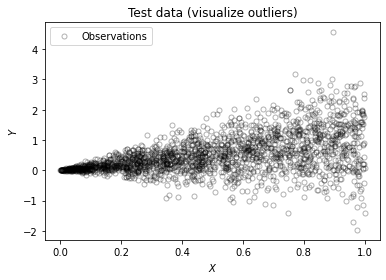

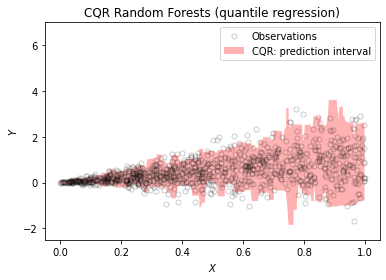

In [36]:
save_figures = False
split_color = 'tomato'
local_color = 'gray'
cqr_color = 'red'
max_show = 1000

%matplotlib inline
# display the test data in full range (including the outliers)
fig = plt.figure()
plt.plot(x_test, y_test, 'k.', alpha = 0.3, markersize=10,
         fillstyle='none', label=u'Observations')
plt.legend()
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title('Test data (visualize outliers)')
if save_figures:
    plt.savefig("illustration_test_data.png",
                bbox_inches='tight', dpi=300)
plt.show()

plot_func(x=x_test,y=y_test,y_u=res[:,1],y_l=res[:,0],shade_color=cqr_color,
          method_name="CQR:",title="CQR Random Forests (quantile regression)",
          filename="illustration_split_qrf.png",save_figures=save_figures)

In [67]:
x, y = test_dgp(2000)
y = y.flatten()
param_grid = {'n_estimators': [5, 900]}
regressor = SplitConformalRegressor(RandomForestRegressor(), method="mean-based", param_grid=param_grid)
#grid = GridSearchCV(RandomForestRegressor(),param_grid, refit = True, scoring=scoring_object)
# fitting the model for grid search 
res = regressor.tune(X=x,y=y)

TypeError: 'RandomForestRegressor' object is not callable

In [35]:
x, y = testing_dgp_1(2000)
x_test, y_test = testing_dgp_1(2000)

y_test = y_test.flatten()
y = y.flatten()

params = {'nodesize': 25, "ntree": 600}

regressor = SplitConformalRegressor(QuantregForest, method="cdf-based", quantiles_to_fit=np.array([0.05,0.95]))
regressor = regressor.fit(X=x,y=y, params=params)
res = regressor.predict_intervals(X_pred=x_test)

length_cqr_rf = res[:,1] - res[:,0]

# compute and display the average length
print("CQR Random Forests: Average length:", np.mean(length_cqr_rf))

in_the_range = np.sum((y_test.flatten() >= res[:,0]) & (y_test.flatten() <= res[:,1]))

print("CQR Random Forests: Percentage in the range (expecting " + str(100*(1-0.1)) + "%):",
      in_the_range / len(y_test) * 100)

CQR Random Forests: Average length: 1.9125120087338168
CQR Random Forests: Percentage in the range (expecting 90.0%): 91.14999999999999


In [15]:
x, y = testing_dgp_1(2000)
x_test, y_test = testing_dgp_1(2000)

y_test = y_test.flatten()
y = y.flatten()

param_grid = {'nodesize': [2, 8, 50]}

regressor = SplitConformalRegressor(QuantregForest, method="quantile-based", param_grid=param_grid, quantiles_to_fit=np.array([0.05,0.95]))
results = regressor.tune(X=x,y=y)
print(results.best_params_)
opt_res = regressor.fit(x,y, params=results.best_params_)

res = opt_res.predict_intervals(X_pred=x_test)

length_cqr_rf = res[:,1] - res[:,0]

# compute and display the average length
print("CQR Random Forests: Average length:", np.mean(length_cqr_rf))

in_the_range = np.sum((y_test.flatten() >= res[:,0]) & (y_test.flatten() <= res[:,1]))

print("CQR Random Forests: Percentage in the range (expecting " + str(100*(1-0.1)) + "%):",
      in_the_range / len(y_test) * 100)


{'alpha': 0.9, 'loss': 'quantile', 'nodesize': 50}
CQR Random Forests: Average length: 1.7299889193339286
CQR Random Forests: Percentage in the range (expecting 90.0%): 91.7


In [19]:
results.best_params_

{'alpha': 0.9,
 'loss': 'quantile',
 'nodesize': 50,
 'quantile_to_fit': array([0.05, 0.95])}

In [21]:
isinstance(results, list)

False

In [70]:
x, y = test_dgp(2000)
y = y.flatten()
#param_grid = {'nodesize': [2, 80]}
param_grid ={}
#param_grid = {'fit_intercept': [True,False]}
#regressor = SplitConformalRegressor(QuantregForest, method="quantile-based", param_grid=param_grid)
regressor = SplitConformalRegressor(LinearRegression, method="mean-based", param_grid=param_grid)
res = regressor.tune(X=x,y=y)

In [74]:
param_grid = {'nodesize': [2, 80]}
regressor = SplitConformalRegressor(QuantregForest, method="quantile-based", param_grid=param_grid)
res = regressor.tune(X=x,y=y)

In [73]:
not {2}

False

In [32]:
x, y = test_dgp(2000)
x_test, y_test = test_dgp(2000)

y_test = y_test.flatten()
y = y.flatten()


#regressor = SplitConformalRegressor(GradientBoostingRegressor, method="quantile-based")
regressor = SplitConformalRegressor(QuantregForest, method="quantile-based", quantiles_to_fit=np.array([0.05,0.95]))

#regressor = regressor.fit(X=x, y=y, params={"alpha": np.array([0.05,0.95]), "loss": 'quantile'})
regressor = regressor.fit(X=x, y=y, params={"nodesize": 25})

res = regressor.predict_intervals(X_pred=x_test)

length_cqr_rf = res[:,1] - res[:,0]

# compute and display the average length
print("CQR Random Forests: Average length:", np.mean(length_cqr_rf))

in_the_range = np.sum((y_test.flatten() >= res[:,0]) & (y_test.flatten() <= res[:,1]))

print("CQR Random Forests: Percentage in the range (expecting " + str(100*(1-0.1)) + "%):",
      in_the_range / len(y_test) * 100)

CQR Random Forests: Average length: 1.6721601729346867
CQR Random Forests: Percentage in the range (expecting 90.0%): 88.75


In [65]:
eps = np.random.normal(0, 1, 1000000)

In [6]:
def testing_dgp_2000(n=2000):
    X = np.random.normal(0, 1, n * 1).reshape((n, 1))
    eps = np.random.normal(0, 1, n)
    return X, eps.flatten()

In [10]:
X, y = testing_dgp_2000(10000)
X_test, y_test = testing_dgp_2000(2000)

param_grid = {'n_estimators': [50, 100, 500], 'max_depth': [2,5,25], 'min_samples_leaf': [1, 3, 15]}
regressor = SplitConformalRegressor(RandomForestRegressor, method="mean-based", param_grid=param_grid)
tuning_res= regressor.tune(X=X,y=y, cv=3)
opt_res = regressor.fit(X,y, params=tuning_res.best_params_)
pred_band = opt_res.predict_intervals(X_pred=X_test, alpha=0.1)
# the mean of the prediction intervals should be approx zero, if fitted function is close to truth (which it should)
np.testing.assert_almost_equal(np.mean(pred_band), 0.0, 1)

in_the_range = np.sum((y_test.flatten() >= pred_band[:,0]) & (y_test.flatten() <= pred_band[:,1]))
coverage = in_the_range / len(y_test)
assert (0.86 < coverage) & (coverage < 0.94)

# check if length is shorter than the non-tuned version:
regressor_non_tuned = SplitConformalRegressor(RandomForestRegressor, method="mean-based")
# strange behavior here, since regressor_non_tuned.fit(X,y, params={}) without the params keyword somehow gets passed 'loss': 'quantile' argument,
# even though the default is params={}
pred_band_non_tuned = regressor_non_tuned.fit(X,y).predict_intervals(X_pred=X_test, alpha=0.1) 

length_opt_band = pred_band[:,1] - pred_band[:,0]
mean_length_opt = np.mean(length_opt_band)

length_non_tuned = pred_band_non_tuned[:,1] - pred_band_non_tuned[:,0]
mean_length_non_tuned = np.mean(length_non_tuned)

assert mean_length_opt < mean_length_non_tuned

In [1]:
import pandas as pd

In [4]:
df = pd.read_csv("/home/helios/Code/Github/conformal-inference/bld/simulations/power_simulations/df_results_gaussian.csv")

In [5]:
df

,n,p,treatment_to_noise_ratio,main_effect_case,treatment_case,simulation_id,mean_oracle_length,mse_train_y1,opt_estimator,mean_interval_length,mean_coverage,mean_interval_length_asy,mean_coverage_asy,mean_interval_length_naive,mean_coverage_naive,mean_interval_length_naive_asymp,mean_coverage_naive_asymp
0,300,10,1.000000,const,gaussian,0,4.652349,-1.020498,lin_reg,8.061906,0.9905,4.671803,0.8785,7.646802,0.9895,4.231597,0.8395
1,300,10,1.000000,const,gaussian,1,4.652349,-1.262465,lin_reg,8.837976,0.9960,5.568246,0.9345,6.911035,0.9805,4.491689,0.8530
2,300,10,1.000000,linear,gaussian,0,4.652349,-1.572119,lin_reg,10.755786,0.9995,4.869989,0.8910,7.294923,0.9845,4.459731,0.8595
3,300,10,1.000000,linear,gaussian,1,4.652349,-1.118989,lin_reg,7.399230,0.9920,4.229024,0.8475,7.405413,0.9920,4.447950,0.8690
4,300,10,1.000000,non-linear,gaussian,0,4.652349,-2.499223,lin_reg,10.937533,0.9965,6.892455,0.9585,10.943507,0.9965,6.252334,0.9390
5,300,10,1.000000,non-linear,gaussian,1,4.652349,-2.028274,lin_reg,11.574819,1.0000,6.365412,0.9655,9.553324,0.9995,5.849436,0.9425
6,300,10,1.369830,const,gaussian,0,4.652349,-1.241708,lin_reg,8.540904,0.9965,5.245337,0.9220,7.678394,0.9895,4.554753,0.8770
7,300,10,1.369830,const,gaussian,1,4.652349,-1.127314,lin_reg,7.808424,0.9830,4.551708,0.8535,8.347456,0.9890,4.485458,0.8490
8,300,10,1.369830,linear,gaussian,0,4.652349,-1.253988,lin_reg,9.032327,0.9985,5.293252,0.9230,7.102944,0.9840,4.329958,0.8555
9,300,10,1.369830,linear,gaussian,1,4.652349,-1.167943,lin_reg,8.851247,0.9960,5.077556,0.8975,6.757849,0.9705,4.347926,0.8490
